# 10. Preprocessing

In [8]:
# df.info()

In [9]:
# EDA -> perlu dikumpulin insight"nya

# Preprocessing Steps
# numerical original = 12 -> impute Median (kalo ada)
# numerical original = 12 -> RobustScaler() 
# ohe -> (Complain + 5 categorical original)
# ordinal encoding -> CityTier, SatisfactionScore

# notes: kalo ada missing categorical pake mode (most_frequent)

# smote oversampling -> handle imbalance
# training model, evaluation dapet best model
    # evaluation before hyperparameter tuning, untuk benchmark -> filter candidate models untuk hyperparameter tuning (misal top 3)
    # hyperparamter tuning candidate models from benchmark -> filter best model untuk next steps
# feature importances + confusion matrix (simulation) -> best model aja
# conclusion & recommendations

# tableau -> Dilham
# streamlit -> Hendra
# pptx

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from collections import Counter
import joblib

# --- Global variable for reproducibility ---
RANDOM_STATE = 42

# --- 1. Load the dataset ---
try:
    df = pd.read_csv('eda.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'eda.csv' not found. Please check the file path.")
    exit()

# --- 2. Define features and target ---
TARGET = 'Churn'

# Categorization based on the provided feedback
# CustomerID is not used as features
df.set_index('CustomerID', inplace=True)

ordinal_features = ['CityTier', 'SatisfactionScore']
numerical_features = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'NumberOfAddress', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']
categorical_features = ['PreferedOrderCat', 'MaritalStatus', 'PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'Complain']

# Separate target variable
X = df.drop(columns=[TARGET])
y = df[TARGET]

# --- 3. Split the data to prevent data leakage ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
print(f"Original data shape: {X.shape}")
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"\nOriginal Churn distribution: {Counter(y)}")
print(f"Training Churn distribution: {Counter(y_train)}")

# --- 4. Define Preprocessing Pipelines ---
# A. Numerical Preprocessor
numerical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# B. Nominal Categorical Preprocessor (One-Hot Encoding)
nominal_preprocessor = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# C. Ordinal Categorical Preprocessor (Ordinal Encoding)
ordinal_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Impute missing values with the most frequent category
    ('ordinal', OrdinalEncoder())
])

# D. Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_preprocessor, numerical_features),
        ('nominal_cat', nominal_preprocessor, categorical_features),
        ('ordinal_cat', ordinal_preprocessor, ordinal_features)
    ],
    remainder='passthrough'
)

# --- 6. Apply Preprocessing to Data ---
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("\nData preprocessing and feature engineering complete.")

# --- 7. Handle Class Imbalance using SMOTE on Training Data Only ---
smote = SMOTE(random_state=RANDOM_STATE)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

print(f"\nOriginal training set size: {X_train_processed.shape[0]}")
print(f"Resampled training set size: {X_train_resampled.shape[0]}")
print(f"Resampled Churn distribution: {Counter(y_train_resampled)}")

# --- 8. Final Ready Data for Modeling ---
print("\nPreprocessing workflow complete. The data is now ready for model training.")

# Save the preprocessor
joblib.dump(preprocessor, 'preprocessor.pkl')
print(f"\nPreprocessor saved to 'preprocessor.pkl'")

Dataset loaded successfully.
Original data shape: (5630, 18)
Training data shape: (4504, 18)
Testing data shape: (1126, 18)

Original Churn distribution: Counter({0: 4682, 1: 948})
Training Churn distribution: Counter({0: 3746, 1: 758})

Data preprocessing and feature engineering complete.

Original training set size: 4504
Resampled training set size: 7492
Resampled Churn distribution: Counter({0: 3746, 1: 3746})

Preprocessing workflow complete. The data is now ready for model training.

Preprocessor saved to 'preprocessor.pkl'


In [11]:
# # --- 1. Define Tableau Preprocessor (imputation only, no scaling/encoding) ---
# numerical_preprocessor_tableau = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='median'))
# ])

# nominal_preprocessor_tableau = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent'))
# ])

# ordinal_preprocessor_tableau = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent'))
# ])

# preprocessor_tableau = ColumnTransformer(
#     transformers=[
#         ('num', numerical_preprocessor_tableau, numerical_features),
#         ('nominal_cat', nominal_preprocessor_tableau, categorical_features),
#         ('ordinal_cat', ordinal_preprocessor_tableau, ordinal_features)
#     ],
#     remainder='passthrough'
# )

# # --- 2. Fit on training set, transform whole dataset ---
# preprocessor_tableau.fit(X_train)          # fit imputers using training data only
# X_all_tableau = preprocessor_tableau.transform(X)   # apply to full dataset

# # Get feature names from preprocessor
# pt_feature_names = preprocessor_tableau.get_feature_names_out()

# # Remove transformer prefixes like "num__", "nominal_cat__", etc.
# clean_feature_names = [name.split("__")[-1] for name in pt_feature_names]

# # --- 3. Convert back to DataFrame ---
# tableau_ready = pd.DataFrame(X_all_tableau, 
#                              columns=clean_feature_names)
# tableau_ready[TARGET] = y.reset_index(drop=True)
# tableau_ready.index = df.index

# # --- 4. Save to CSV ---
# tableau_ready.to_csv("tableau_ready.csv")
# print("\n✅ Tableau-ready dataset saved as 'tableau_ready.csv'")

In [12]:
# If X_test is still a DataFrame after preprocessing
test_df = X_test.copy()
test_df['Churn'] = y_test.values

# If X_test is a NumPy array after preprocessing
# you’ll need to bring back the feature names
if not isinstance(X_test, pd.DataFrame):
    feature_names = preprocessor.get_feature_names_out()
    test_df = pd.DataFrame(X_test, columns=feature_names)
    test_df['Churn'] = y_test.values

# Save to CSV for inspection or later use
test_df.to_csv("test_set.csv")

print("Test set saved successfully with shape:", test_df.shape)

Test set saved successfully with shape: (1126, 19)


# 11. Model Train & Evaluation

## 11.1. Benchmark Model


--- Benchmarking Models Without Hyperparameter Tuning ---

Training LogisticRegression (default params)...
Classification Report for LogisticRegression:

              precision    recall  f1-score   support

           0       0.96      0.79      0.87       936
           1       0.44      0.83      0.58       190

    accuracy                           0.80      1126
   macro avg       0.70      0.81      0.72      1126
weighted avg       0.87      0.80      0.82      1126



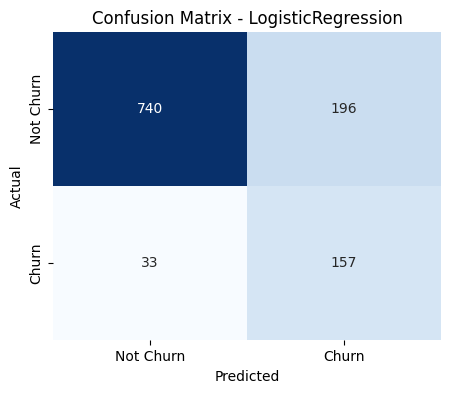


Training KNeighborsClassifier (default params)...
Classification Report for KNeighborsClassifier:

              precision    recall  f1-score   support

           0       0.99      0.87      0.92       936
           1       0.59      0.96      0.73       190

    accuracy                           0.88      1126
   macro avg       0.79      0.91      0.83      1126
weighted avg       0.92      0.88      0.89      1126



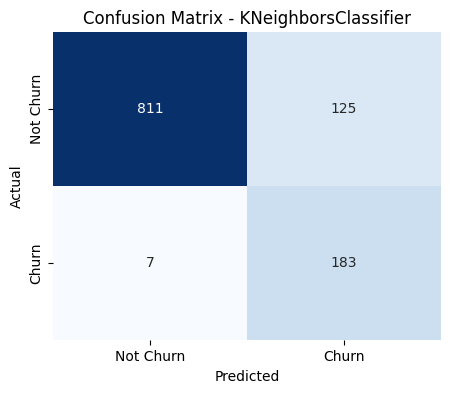


Training DecisionTreeClassifier (default params)...
Classification Report for DecisionTreeClassifier:

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       936
           1       0.84      0.94      0.89       190

    accuracy                           0.96      1126
   macro avg       0.92      0.95      0.93      1126
weighted avg       0.96      0.96      0.96      1126



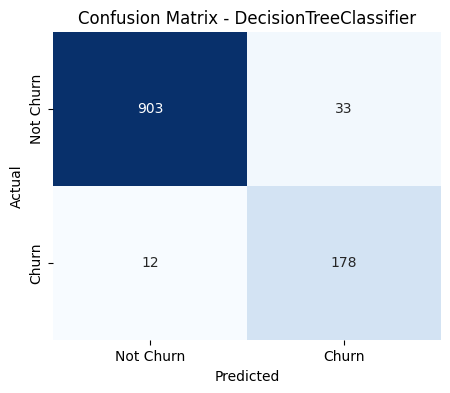


Training RandomForestClassifier (default params)...
Classification Report for RandomForestClassifier:

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       936
           1       0.93      0.88      0.91       190

    accuracy                           0.97      1126
   macro avg       0.95      0.94      0.94      1126
weighted avg       0.97      0.97      0.97      1126



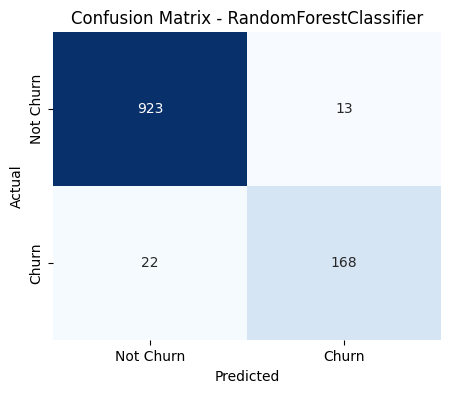


Training XGBClassifier (default params)...
Classification Report for XGBClassifier:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       936
           1       0.96      0.96      0.96       190

    accuracy                           0.99      1126
   macro avg       0.98      0.98      0.98      1126
weighted avg       0.99      0.99      0.99      1126



/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:50:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


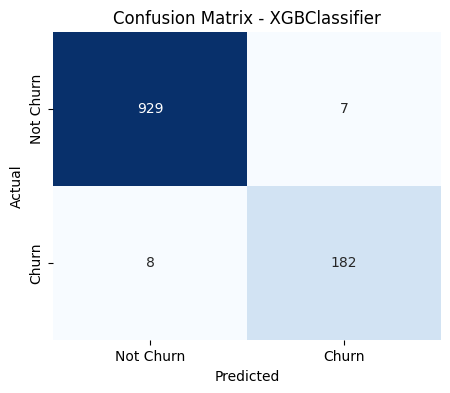


--- Simple Models Results Summary (No Tuning, Sorted by F2-Score) ---
                 Model  F2-Score  ROC-AUC  F3-Score  F4-Score  Precision   Recall
         XGBClassifier  0.958904 0.997627  0.958399  0.958191   0.962963 0.957895
DecisionTreeClassifier  0.916581 0.950793  0.926601  0.930791   0.843602 0.936842
RandomForestClassifier  0.892667 0.995133  0.888419  0.886681   0.928177 0.884211
  KNeighborsClassifier  0.856742 0.968466  0.906838  0.929211   0.594156 0.963158
    LogisticRegression  0.705301 0.882720  0.761028  0.786620   0.444759 0.826316


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Import all necessary models and metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import fbeta_score, roc_auc_score, precision_score, recall_score, classification_report, confusion_matrix, make_scorer

# --- Benchmark Models Without Hyperparameter Tuning ---
print("\n--- Benchmarking Models Without Hyperparameter Tuning ---")

simple_models = {
    'LogisticRegression': LogisticRegression(random_state=RANDOM_STATE, solver='liblinear'),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'RandomForestClassifier': RandomForestClassifier(random_state=RANDOM_STATE),
    'XGBClassifier': XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss')
}

results_simple = []

for name, model in simple_models.items():
    print(f"\nTraining {name} (default params)...")
    model.fit(X_train_resampled, y_train_resampled)

    y_pred = model.predict(X_test_processed)
    y_pred_proba = model.predict_proba(X_test_processed)[:, 1] if hasattr(model, 'predict_proba') else None

    f2 = fbeta_score(y_test, y_pred, beta=2)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 'N/A'
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f3 = fbeta_score(y_test, y_pred, beta=3)
    f4 = fbeta_score(y_test, y_pred, beta=4)
    conf_matrix = confusion_matrix(y_test, y_pred)

    results_simple.append({
        'Model': name,
        'F2-Score': f2,
        'ROC-AUC': roc_auc,
        'F3-Score': f3,
        'F4-Score': f4,
        'Precision': precision,
        'Recall': recall
    })
    
    print(f"Classification Report for {name}:\n")
    print(classification_report(y_test, y_pred, zero_division=0))

    # --- Plot Confusion Matrix ---
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Not Churn", "Churn"], 
                yticklabels=["Not Churn", "Churn"])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# --- Results Summary ---
results_simple_df = pd.DataFrame(results_simple).sort_values(by='F2-Score', ascending=False)
print("\n--- Simple Models Results Summary (No Tuning, Sorted by F2-Score) ---")
print(results_simple_df.to_string(index=False))


## 11.2. Hyperparameter Tuning

--- Starting Model Training & Hyperparameter Tuning ---

Training and tuning LogisticRegression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for LogisticRegression: {'C': 100, 'penalty': 'l1'}
Best F2-Score on training data: 0.8356

Training and tuning KNeighborsClassifier...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for KNeighborsClassifier: {'n_neighbors': 3, 'weights': 'distance'}
Best F2-Score on training data: 0.9815

Training and tuning DecisionTreeClassifier...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for DecisionTreeClassifier: {'max_depth': None, 'min_samples_split': 2}
Best F2-Score on training data: 0.9495

Training and tuning RandomForestClassifier...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for RandomForestClassifier: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}
Best F2-Score on training data: 0.9810

Training and 

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:51:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:51:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:51:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:51:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not

Best parameters for XGBClassifier: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Best F2-Score on training data: 0.9829

--- Final Model Evaluation on the Test Set ---

Evaluating LogisticRegression...
Classification Report for LogisticRegression:

              precision    recall  f1-score   support

           0       0.96      0.79      0.87       936
           1       0.44      0.82      0.58       190

    accuracy                           0.80      1126
   macro avg       0.70      0.81      0.72      1126
weighted avg       0.87      0.80      0.82      1126

Confusion Matrix for LogisticRegression:

[[741 195]
 [ 34 156]]


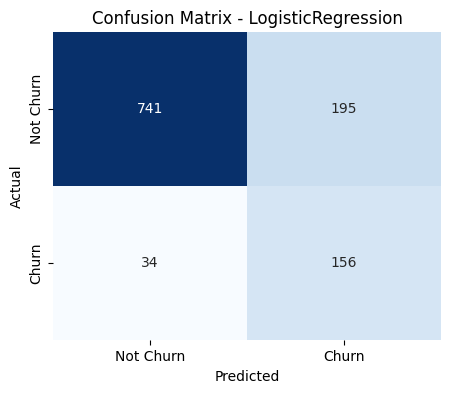


Evaluating KNeighborsClassifier...
Classification Report for KNeighborsClassifier:

              precision    recall  f1-score   support

           0       0.99      0.92      0.96       936
           1       0.72      0.96      0.82       190

    accuracy                           0.93      1126
   macro avg       0.86      0.94      0.89      1126
weighted avg       0.95      0.93      0.93      1126

Confusion Matrix for KNeighborsClassifier:

[[865  71]
 [  8 182]]


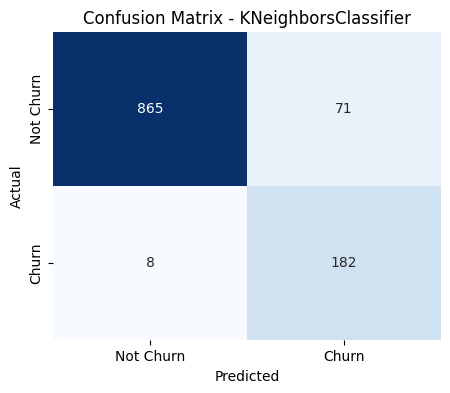


Evaluating DecisionTreeClassifier...
Classification Report for DecisionTreeClassifier:

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       936
           1       0.84      0.94      0.89       190

    accuracy                           0.96      1126
   macro avg       0.92      0.95      0.93      1126
weighted avg       0.96      0.96      0.96      1126

Confusion Matrix for DecisionTreeClassifier:

[[903  33]
 [ 12 178]]


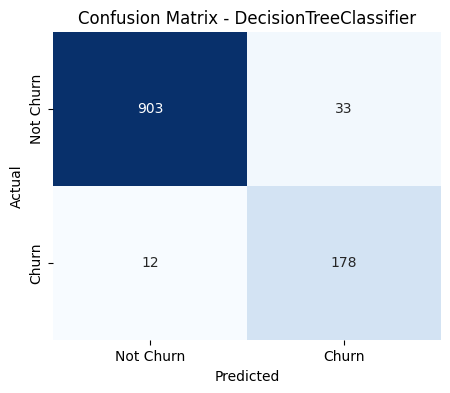


Evaluating RandomForestClassifier...
Classification Report for RandomForestClassifier:

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       936
           1       0.93      0.88      0.91       190

    accuracy                           0.97      1126
   macro avg       0.95      0.94      0.94      1126
weighted avg       0.97      0.97      0.97      1126

Confusion Matrix for RandomForestClassifier:

[[923  13]
 [ 22 168]]


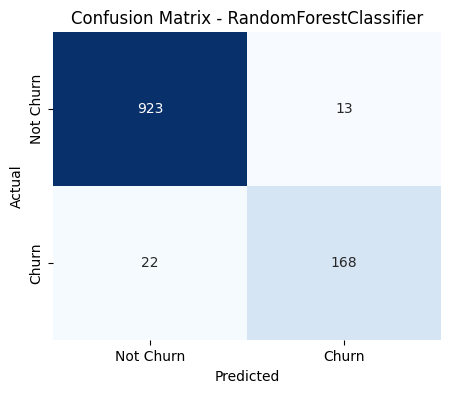


Evaluating XGBClassifier...
Classification Report for XGBClassifier:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       936
           1       0.97      0.96      0.97       190

    accuracy                           0.99      1126
   macro avg       0.98      0.98      0.98      1126
weighted avg       0.99      0.99      0.99      1126

Confusion Matrix for XGBClassifier:

[[931   5]
 [  8 182]]


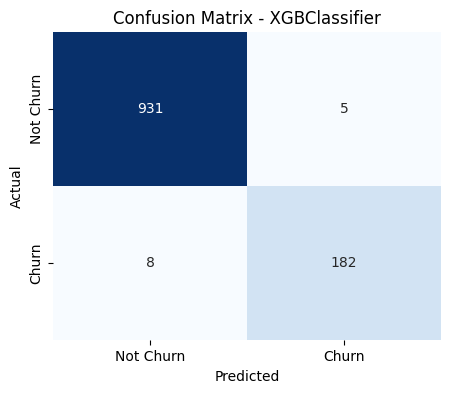


--- Final Results Summary (Sorted by F2-Score) ---
                 Model  F2-Score  ROC-AUC  F3-Score  F4-Score  Precision   Recall
         XGBClassifier  0.960929 0.998459  0.959410  0.958785   0.973262 0.957895
DecisionTreeClassifier  0.916581 0.950793  0.926601  0.930791   0.843602 0.936842
  KNeighborsClassifier  0.898322 0.976046  0.927152  0.939569   0.719368 0.957895
RandomForestClassifier  0.892667 0.995133  0.888419  0.886681   0.928177 0.884211
    LogisticRegression  0.702070 0.883120  0.756914  0.782070   0.444444 0.821053

Final Best Model: XGBClassifier with an F2-Score of 0.9609

Best model 'XGBClassifier' saved to 'best_benchmark_model.pkl'


In [14]:
import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import StratifiedKFold, GridSearchCV

# --- 1. Define Models and Hyperparameter Grids ---
# A dictionary to hold all models and their tuning grids.
models = {
    'LogisticRegression': {
        'model': LogisticRegression(random_state=RANDOM_STATE, solver='liblinear'),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2']
        }
    },
    'KNeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance']
        }
    },
    'DecisionTreeClassifier': {
        'model': DecisionTreeClassifier(random_state=RANDOM_STATE),
        'params': {
            'max_depth': [5, 10, 15, None],
            'min_samples_split': [2, 5, 10]
        }
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(random_state=RANDOM_STATE),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, None],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'XGBClassifier': {
        'model': XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    }
}

# --- 2. Custom Scorers for Evaluation ---
f2_scorer = make_scorer(fbeta_score, beta=2)
f3_scorer = make_scorer(fbeta_score, beta=3)
f4_scorer = make_scorer(fbeta_score, beta=4)
precision_scorer = make_scorer(precision_score)
roc_auc_scorer = make_scorer(roc_auc_score)
recall_scorer = make_scorer(recall_score)

scoring_metrics = {
    'F2-Score': f2_scorer,
    'ROC-AUC': roc_auc_scorer,
    'F3-Score': f3_scorer,
    'F4-Score': f4_scorer,
    'Precision': precision_scorer,
    'Recall': recall_scorer
}

# --- 3. Hyperparameter Tuning and Cross-Validation ---
best_models = {}
best_params = {}
best_score = 0
best_model_name = ''

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print("--- Starting Model Training & Hyperparameter Tuning ---")

for name, item in models.items():
    print(f"\nTraining and tuning {name}...")
    
    grid_search = GridSearchCV(
        estimator=item['model'],
        param_grid=item['params'],
        scoring=f2_scorer,
        cv=cv,
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train_resampled, y_train_resampled)
    
    best_models[name] = grid_search.best_estimator_
    best_params[name] = grid_search.best_params_
    
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best F2-Score on training data: {grid_search.best_score_:.4f}")

# --- 4. Final Evaluation on the Test Set ---
print("\n--- Final Model Evaluation on the Test Set ---")
results = []

for name, model in best_models.items():
    print(f"\nEvaluating {name}...")
    y_pred = model.predict(X_test_processed)
    y_pred_proba = model.predict_proba(X_test_processed)[:, 1] if hasattr(model, 'predict_proba') else None

    f2 = fbeta_score(y_test, y_pred, beta=2)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 'N/A'
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f3 = fbeta_score(y_test, y_pred, beta=3)
    f4 = fbeta_score(y_test, y_pred, beta=4)
    conf_matrix = confusion_matrix(y_test, y_pred)

    results.append({
        'Model': name,
        'F2-Score': f2,
        'ROC-AUC': roc_auc,
        'F3-Score': f3,
        'F4-Score': f4,
        'Precision': precision,
        'Recall': recall
    })
    
    print(f"Classification Report for {name}:\n")
    print(classification_report(y_test, y_pred, zero_division=0))
    print(f"Confusion Matrix for {name}:\n")
    print(conf_matrix)

    # --- Plot Confusion Matrix ---
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Not Churn", "Churn"], 
                yticklabels=["Not Churn", "Churn"])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# --- 5. Decide the Best Model ---
results_df = pd.DataFrame(results).sort_values(by='F2-Score', ascending=False)
print("\n--- Final Results Summary (Sorted by F2-Score) ---")
print(results_df.to_string(index=False))

best_model = results_df.iloc[0]
print(f"\nFinal Best Model: {best_model['Model']} with an F2-Score of {best_model['F2-Score']:.4f}")

best_model_name = results_df.iloc[0]['Model']
best_model_instance = best_models[best_model_name]

# Save the best model
joblib.dump(best_model_instance, 'best_benchmark_model.pkl')
print(f"\nBest model '{best_model_name}' saved to 'best_benchmark_model.pkl'")

Test Load Model

In [15]:
# import joblib
# import pandas as pd
# import numpy as np
# from sklearn.metrics import classification_report, fbeta_score

# # Assuming the following variables are available from your previous script:
# # X_test_processed, y_test, and best_model_name

# # --- 1. Load the saved model ---
# try:
#     best_model_instance = joblib.load('best_benchmark_model.pkl')
#     print("Model 'best_benchmark_model.pkl' loaded successfully.")
    
# except FileNotFoundError:
#     print("Error: The model file 'best_benchmark_model.pkl' was not found.")
#     best_model_instance = None

# if best_model_instance:
#     # --- 2. Make predictions on the test set ---
#     y_pred_loaded = best_model_instance.predict(X_test_processed)
    
#     # --- 3. Evaluate the loaded model's performance ---
#     f2_loaded = fbeta_score(y_test, y_pred_loaded, beta=2)
    
#     print("\n--- Evaluation of Loaded Model ---")
#     print(f"Loaded model's F2-Score on test set: {f2_loaded:.4f}")
#     print("\nClassification Report of Loaded Model:")
#     print(classification_report(y_test, y_pred_loaded))

#     # --- 4. Cross-check with the original best model's score ---
#     # This assumes you have the 'best_model_name' and the 'best_models' dictionary from the previous cell
#     # You can get the score of the original best model by re-evaluating it.
#     y_pred_original = best_models[best_model_name].predict(X_test_processed)
#     f2_original = fbeta_score(y_test, y_pred_original, beta=2)
    
#     print(f"\nOriginal best model's F2-Score: {f2_original:.4f}")

#     if np.isclose(f2_loaded, f2_original):
#         print("✅ Success: The scores match. The model was loaded correctly.")
#     else:
#         print("❌ Warning: The scores do not match. There might be an issue with the saved model.")

# 12. Feature Importances

In [16]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score, classification_report, roc_auc_score, precision_score

# --- 2. Feature Importance & Selection (Corrected) ---
print("\n--- Feature Importance Analysis ---")
feature_names = preprocessor.get_feature_names_out()

target_n_features = 20

if hasattr(best_model_instance, 'feature_importances_'):
    importances = best_model_instance.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    print(f"Top {target_n_features} Most Important Features:")
    print(feature_importance_df.head(target_n_features).to_string(index=False))

    # --- 3. Retrain on Important Features Only ---
    top_features_list = feature_importance_df['Feature'].head(target_n_features).tolist()

    # Get the indices of the top features in the processed data
    top_feature_indices = [np.where(feature_names == f)[0][0] for f in top_features_list]

    # Create the new reduced datasets by slicing the processed data
    X_train_reduced_resampled = X_train_resampled[:, top_feature_indices]
    X_test_reduced_processed = X_test_processed[:, top_feature_indices]

    print(f"\nTraining on a reduced set of {len(top_features_list)} features.")
    
    # Retrain the best model with its best parameters on the reduced feature set
    simplified_model = best_model_instance.__class__(**best_model_instance.get_params())
    simplified_model.fit(X_train_reduced_resampled, y_train_resampled)

    # --- 4. Evaluate and Compare ---
    # Predictions for the original model
    y_pred_original = best_model_instance.predict(X_test_processed)
    y_pred_proba_original = best_model_instance.predict_proba(X_test_processed)[:, 1] if hasattr(best_model_instance, 'predict_proba') else None
    
    # Predictions for the simplified model
    y_pred_simplified = simplified_model.predict(X_test_reduced_processed)
    y_pred_proba_simplified = simplified_model.predict_proba(X_test_reduced_processed)[:, 1] if hasattr(simplified_model, 'predict_proba') else None

    # Calculate metrics for original model
    f2_original = fbeta_score(y_test, y_pred_original, beta=2)
    f3_original = fbeta_score(y_test, y_pred_original, beta=3)
    f4_original = fbeta_score(y_test, y_pred_original, beta=4)
    precision_original = precision_score(y_test, y_pred_original)
    roc_auc_original = roc_auc_score(y_test, y_pred_proba_original) if y_pred_proba_original is not None else 'N/A'

    # Calculate metrics for simplified model
    f2_simplified = fbeta_score(y_test, y_pred_simplified, beta=2)
    f3_simplified = fbeta_score(y_test, y_pred_simplified, beta=3)
    f4_simplified = fbeta_score(y_test, y_pred_simplified, beta=4)
    precision_simplified = precision_score(y_test, y_pred_simplified)
    roc_auc_simplified = roc_auc_score(y_test, y_pred_proba_simplified) if y_pred_proba_simplified is not None else 'N/A'


    print("\n--- Performance Comparison (Full vs. Simplified Model) ---")
    results_df = pd.DataFrame({
        'Metric': ['F2-Score', 'ROC-AUC', 'F3-Score', 'F4-Score', 'Precision'],
        'Full Model': [f2_original, roc_auc_original, f3_original, f4_original, precision_original],
        'Simplified Model': [f2_simplified, roc_auc_simplified, f3_simplified, f4_simplified, precision_simplified]
    })
    print(results_df.to_string(index=False))

    print("\nSimplified Model Classification Report:")
    print(classification_report(y_test, y_pred_simplified))

    if f2_simplified >= (f2_original * 0.95):
        print("\nConclusion: The simplified model performs comparably to the full model.")
        print("This model is more interpretable and can be used for the Streamlit simulation.")
        joblib.dump(simplified_model, 'simplified_best_model.pkl')
        joblib.dump(top_features_list, 'simplified_features.pkl')
        print("Simplified model and its feature list saved successfully.")
    else:
        print("\nConclusion: The performance drop is significant.")
        print("It is recommended to use the full model for the simulation to maintain accuracy.")
else:
    print("The best model does not have a 'feature_importances_' attribute.")


--- Feature Importance Analysis ---
Top 20 Most Important Features:
                                           Feature  Importance
                                       num__Tenure    0.120086
             nominal_cat__PreferedOrderCat_Grocery    0.108384
                           nominal_cat__Complain_0    0.106523
  nominal_cat__PreferedOrderCat_Laptop & Accessory    0.051318
                     num__NumberOfDeviceRegistered    0.050162
        nominal_cat__PreferedOrderCat_Mobile Phone    0.050098
             nominal_cat__PreferedOrderCat_Fashion    0.047481
                           nominal_cat__Complain_1    0.039626
                              num__NumberOfAddress    0.030921
                 nominal_cat__MaritalStatus_Single    0.030809
                             ordinal_cat__CityTier    0.029241
        nominal_cat__PreferredPaymentMode_E wallet    0.027469
    nominal_cat__PreferredLoginDevice_Mobile Phone    0.026886
                nominal_cat__MaritalStatus_Marrie

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:51:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Performance Comparison (Full vs. Simplified Model) ---
   Metric  Full Model  Simplified Model
 F2-Score    0.960929          0.917722
  ROC-AUC    0.998459          0.993511
 F3-Score    0.959410          0.916754
 F4-Score    0.958785          0.916357
Precision    0.973262          0.925532

Simplified Model Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       936
           1       0.93      0.92      0.92       190

    accuracy                           0.97      1126
   macro avg       0.95      0.95      0.95      1126
weighted avg       0.97      0.97      0.97      1126


Conclusion: The simplified model performs comparably to the full model.
This model is more interpretable and can be used for the Streamlit simulation.
Simplified model and its feature list saved successfully.


/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



--- Feature Importance & SHAP Analysis ---
Top 20 Most Important Features (Model-based):
                                           Feature  Importance
                                       num__Tenure    0.120086
             nominal_cat__PreferedOrderCat_Grocery    0.108384
                           nominal_cat__Complain_0    0.106523
  nominal_cat__PreferedOrderCat_Laptop & Accessory    0.051318
                     num__NumberOfDeviceRegistered    0.050162
        nominal_cat__PreferedOrderCat_Mobile Phone    0.050098
             nominal_cat__PreferedOrderCat_Fashion    0.047481
                           nominal_cat__Complain_1    0.039626
                              num__NumberOfAddress    0.030921
                 nominal_cat__MaritalStatus_Single    0.030809
                             ordinal_cat__CityTier    0.029241
        nominal_cat__PreferredPaymentMode_E wallet    0.027469
    nominal_cat__PreferredLoginDevice_Mobile Phone    0.026886
                nominal_cat_

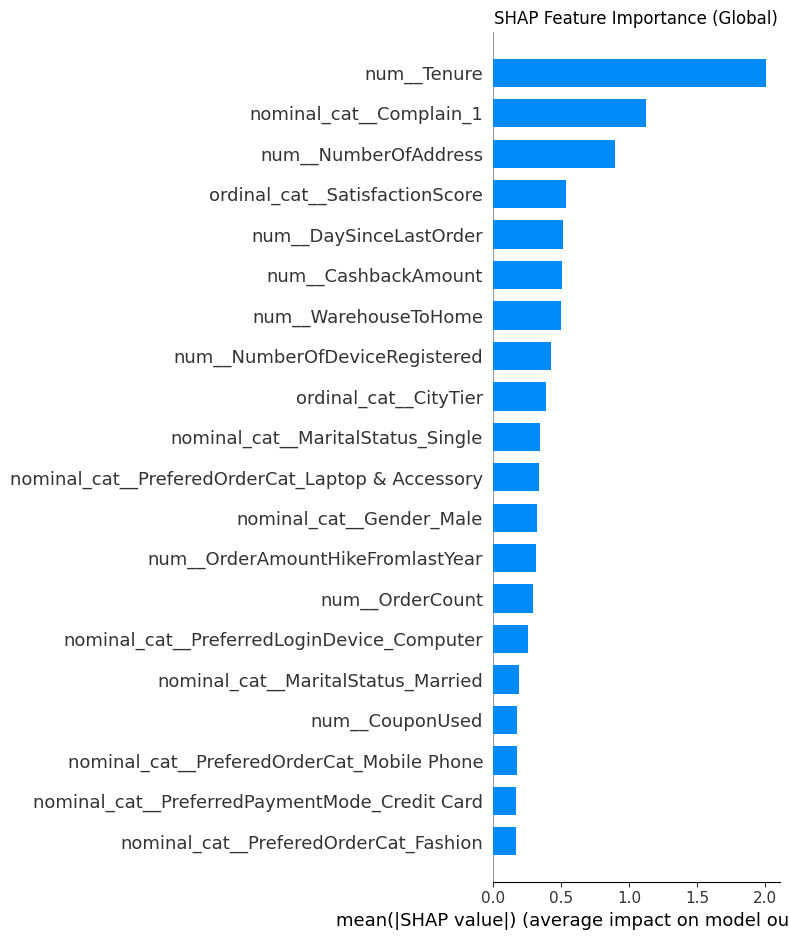

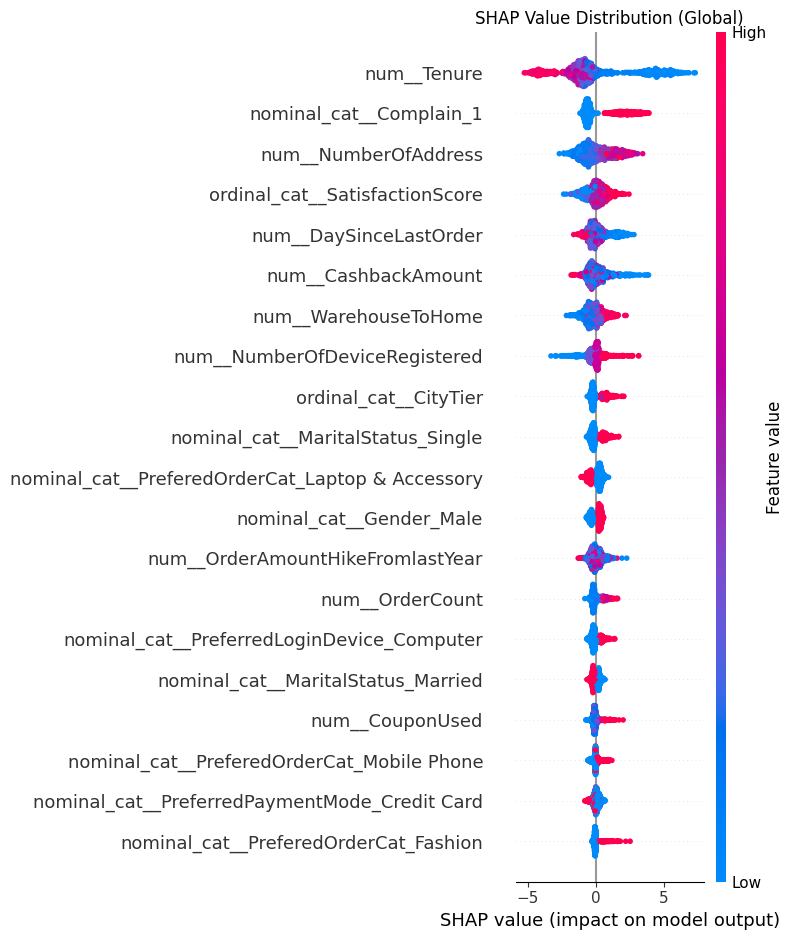

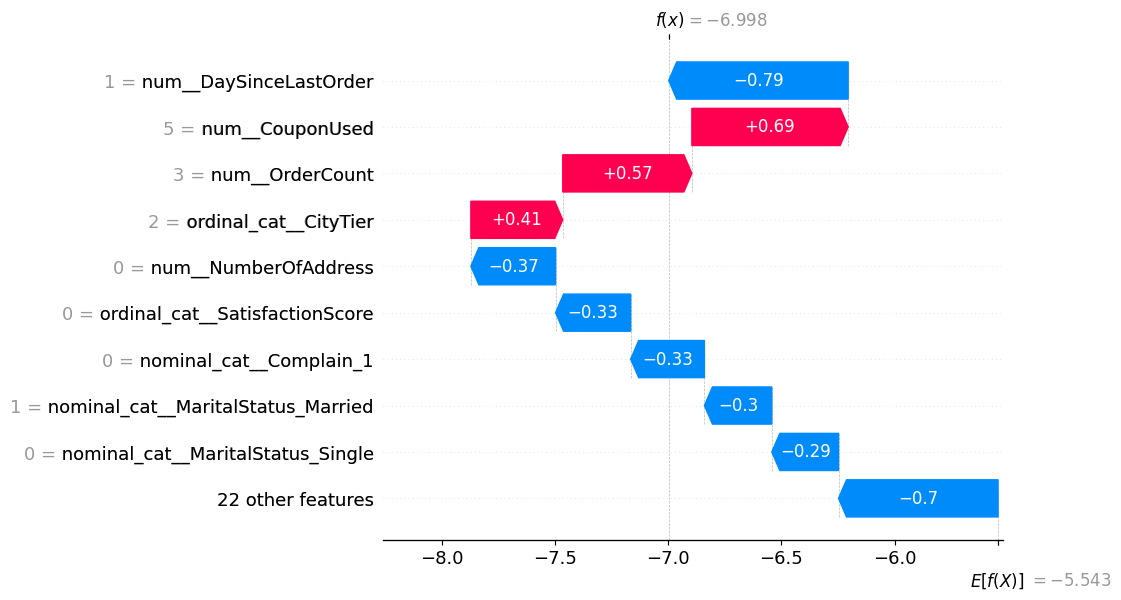

In [17]:
import shap

# --- 2. Feature Importance & SHAP Analysis ---
print("\n--- Feature Importance & SHAP Analysis ---")

# Get feature names from preprocessor
feature_names = preprocessor.get_feature_names_out()

target_n_features = 20

# --- Tree-based models (with feature_importances_) ---
if hasattr(best_model_instance, 'feature_importances_'):
    importances = best_model_instance.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    print(f"Top {target_n_features} Most Important Features (Model-based):")
    print(feature_importance_df.head(target_n_features).to_string(index=False))

# --- SHAP Analysis ---
print("\n--- SHAP Value Analysis ---")

# Use a sample of the test set for SHAP (to save time & memory)
# X_sample = X_test_processed[:200]
X_sample = X_test_processed.copy()

# Initialize SHAP explainer
try:
    explainer = shap.Explainer(best_model_instance, X_sample, feature_names=feature_names)
    shap_values = explainer(X_sample)

    # SHAP summary plot (bar plot for global importance)
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type="bar", show=False)
    plt.title("SHAP Feature Importance (Global)")
    plt.tight_layout()
    plt.show()

    # SHAP beeswarm plot (distribution of feature impacts)
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)
    plt.title("SHAP Value Distribution (Global)")
    plt.tight_layout()
    plt.show()

    # Optional: visualize a single prediction
    shap.plots.waterfall(shap_values[0])

except Exception as e:
    print(f"SHAP analysis failed: {e}")

# --- Continue with Reduced Feature Training as in your original code ---


The charts present two different methods for determining feature importance in a churn prediction model. The first is a SHAP (SHapley Additive exPlanations) summary plot, and the second is a more traditional feature importance ranking. Both provide insights into which variables have the most impact on the model's output.

---

## SHAP Feature Importance Analysis

The SHAP plot ranks features by their average impact on the model's output magnitude. A longer bar indicates a more significant influence on predicting churn.

1.  **Tenure** is the most impactful feature, having the greatest influence on the model's churn predictions. This suggests that the length of time a customer has been with the company is a primary driver of churn.
2.  **Complaint_1** (having a complaint) is the second most important feature, indicating that whether or not a customer has complained has a strong influence on the model's prediction.
3.  **NumberOfAddress** and **SatisfactionScore** are also highly influential features, ranking third and fourth respectively.

---

## Top 20 Most Important Features

This list provides a ranked order of feature importance based on a different methodology, likely from a tree-based model. While the exact values differ, the top features are generally consistent.

1.  **Tenure** is again ranked as the most important feature.
2.  **PreferredOrderCat_Grocery** is ranked as the second most important feature, highlighting that customers who prefer ordering groceries are significantly different from others in terms of churn.
3.  **PreferredOrderCat_Laptop & Accessory** also ranks highly, indicating this category has a notable impact on the model's predictions.

---

## Key Takeaways

* **Tenure is the single most important factor** for predicting churn, according to both analyses. This reinforces that customer loyalty, as measured by tenure, is a critical variable.
* **Customer behavior** such as having a complaint, the number of addresses they have, and their preferred order category (like groceries or laptops) are also strong predictors of churn.
* **Satisfaction Score** is a moderately important feature in the SHAP analysis, but it ranks lower in the second list. This difference may be due to the different methods used, but it still confirms that satisfaction plays a role in churn.
* The analyses collectively indicate that the most significant predictors of churn are **Tenure**, followed by **Complaints**, and then **Customer demographics and behavior**.

# 13. Conclusion & Recommendations

## 📈 Conclusions
* Churn is highly concentrated among **new, unmarried customers, and the most dissatisfied customers** (those with a satisfaction score of 5).
* **Customer support quality, effective complaint resolution**, and personalized engagement incentives like **cashback and coupons** are key levers for churn reduction.
* Retention strategies should be **segmented** not only by tenure, satisfaction, and activity level but also by **marital status, city tier, and preferred product category** to address the highest-risk groups.

## ✅ Business Recommendations
### 1. Onboarding & Early Retention
* Create a **"first 3 months" program** with discounts, loyalty points, or personalized offers, specifically targeting **new customers with a short tenure**.
* Send reactivation nudges if **DaySinceLastOrder > median (≈2–3 days)**.

### 2. Customer Support & Complaints
* Implement a **24-hour SLA** for complaint resolution, as customers who complain are the highest churn risk.
* Provide compensation (e.g., coupons, cashback) after service failures, particularly for those in high-risk categories like **Mobile Phone buyers**.

### 3. Satisfaction Monitoring
* Run post-purchase **satisfaction/NPS surveys**.
* **Target customers with high satisfaction scores (e.g., 4 or 5)** with immediate recovery campaigns, as these are your most dissatisfied customers and highest churn risk.

### 4. Cashback & Loyalty Programs
* Expand cashback or loyalty tiers for **at-risk customers**, particularly those with a lower CashbackAmount.
* Reward repeat purchases through **points-based loyalty programs** to encourage engagement and increase tenure.

### 5. Behavior-Based Retention
* Trigger reactivation offers if customers become inactive.
* Offer personalized discounts for volatile segments like **Fashion or Mobile Phone buyers** and avoid relying on a one-size-fits-all approach.
* **Review payment methods**: Given the high churn rate for "Cash on Delivery," consider incentives to encourage a shift to other payment modes like UPI or credit/debit cards.

### 6. Segmentation & Personalization
* Focus on the **Single + Short Tenure + High Dissatisfaction** (Satisfaction Score 5) demographic as the **highest-risk churn cluster**.
* Customize campaigns by **City Tier** (e.g., Tier-2/3 may be more price-sensitive and respond better to direct discounts, while Tier-1 customers might value faster delivery or premium support).
* Target users who registered more devices with personalized offers to increase their commitment to a single platform.

## ⚡ Business Impact
* Reducing churn from **16% → 10% monthly** can significantly improve retention.
* Over a year, this could yield **>20% higher customer retention**.
* Since acquiring new customers costs **5–25x more** than retaining existing ones, these targeted strategies provide a substantial **ROI**, focusing resources on the most impactful retention levers.